In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.math import confusion_matrix

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 2000)

In [2]:
# Define integer encoding for the 6 classes:
activity_to_code = {'dws': 0, 'ups': 1, 'sit': 2, 'std': 3, 'wlk': 4, 'jog': 5}
code_to_activity = {v:k for k,v in activity_to_code.items()}

In [3]:
df = pd.read_csv(r'../processed_data_100_25.csv')
# df = pd.read_csv(r'../processed_data_100_50.csv')
# df = pd.read_csv(r'../processed_data_200_50.csv')
# df = pd.read_csv(r'../processed_data_200_100.csv')
# df = pd.read_csv(r'../processed_data_300_75.csv')
# df = pd.read_csv(r'../processed_data_300_150.csv')

df = df.drop(columns = ['index_range', 'subject', 'experiment'])

# Convert labels to numbers
df = df.replace(activity_to_code)

# Shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,attitude.roll_min,attitude.roll_max,attitude.roll_median,attitude.roll_std,attitude.roll_skew,attitude.pitch_min,attitude.pitch_max,attitude.pitch_median,attitude.pitch_std,attitude.pitch_skew,attitude.yaw_min,attitude.yaw_max,attitude.yaw_median,attitude.yaw_std,attitude.yaw_skew,gravity.x_min,gravity.x_max,gravity.x_median,gravity.x_std,gravity.x_skew,gravity.y_min,gravity.y_max,gravity.y_median,gravity.y_std,gravity.y_skew,gravity.z_min,gravity.z_max,gravity.z_median,gravity.z_std,gravity.z_skew,rotationRate.x_min,rotationRate.x_max,rotationRate.x_median,rotationRate.x_std,rotationRate.x_skew,rotationRate.y_min,rotationRate.y_max,rotationRate.y_median,rotationRate.y_std,rotationRate.y_skew,rotationRate.z_min,rotationRate.z_max,rotationRate.z_median,rotationRate.z_std,rotationRate.z_skew,userAcceleration.x_min,userAcceleration.x_max,userAcceleration.x_median,userAcceleration.x_std,userAcceleration.x_skew,userAcceleration.y_min,userAcceleration.y_max,userAcceleration.y_median,userAcceleration.y_std,userAcceleration.y_skew,userAcceleration.z_min,userAcceleration.z_max,userAcceleration.z_median,userAcceleration.z_std,userAcceleration.z_skew,attitude.roll_max_amp,attitude.roll_main_freq,attitude.roll_num_freq,attitude.pitch_max_amp,attitude.pitch_main_freq,attitude.pitch_num_freq,attitude.yaw_max_amp,attitude.yaw_main_freq,attitude.yaw_num_freq,gravity.x_max_amp,gravity.x_main_freq,gravity.x_num_freq,gravity.y_max_amp,gravity.y_main_freq,gravity.y_num_freq,gravity.z_max_amp,gravity.z_main_freq,gravity.z_num_freq,rotationRate.x_max_amp,rotationRate.x_main_freq,rotationRate.x_num_freq,rotationRate.y_max_amp,rotationRate.y_main_freq,rotationRate.y_num_freq,rotationRate.z_max_amp,rotationRate.z_main_freq,rotationRate.z_num_freq,userAcceleration.x_max_amp,userAcceleration.x_main_freq,userAcceleration.x_num_freq,userAcceleration.y_max_amp,userAcceleration.y_main_freq,userAcceleration.y_num_freq,userAcceleration.z_max_amp,userAcceleration.z_main_freq,userAcceleration.z_num_freq,activity
0,-0.442243,0.442176,0.058427,3.077099e-01,-0.163511,-0.059027,0.037123,-0.011732,0.033305,0.047817,-1.458927,1.458441,0.140834,1.072298,-0.087957,-0.123148,-0.023471,-0.067626,3.407939e-02,-0.154449,0.762209,0.762209,0.762209,3.636260e-16,0.0,-0.227025,0.226949,0.021915,0.166861,-0.087957,-1.758168,1.758322,-0.232433,1.265896,0.144736,-0.664573,0.540176,-0.013179,0.290483,-0.310771,-0.079780,0.468483,0.158101,0.197368,0.144736,-0.186679,0.168151,-0.010893,8.945397e-02,0.070099,-0.005423,0.141355,0.064251,0.049305,0.052329,0.255049,0.255049,0.255049,8.661062e-17,0.000000,4.588602,1,44,1.949300,8,48,68.065772,4,50,0.514952,1,43,76.220890,0,39,10.591783,4,50,48.300796,3,50,7.745147,7,74,18.116750,0,51,2.636498,12,50,6.607845,0,49,25.504944,0,45,4
1,-0.956161,0.955844,-0.054391,6.917989e-01,0.040623,-0.157535,0.126277,0.023238,0.080690,-0.497702,-0.809659,1.690817,0.399809,0.887882,0.032076,-0.020185,0.002265,-0.009912,6.606509e-03,0.119390,0.923666,0.923666,0.923666,0.000000e+00,0.0,0.121523,0.143600,0.132996,0.006474,-0.055822,-1.755496,1.754451,0.384645,1.210119,-0.258213,-2.475819,2.197352,-0.090231,1.216549,0.106069,-0.743772,0.740079,0.033482,0.500301,-0.054134,-0.788069,0.432138,0.031688,2.760390e-01,-0.820253,-1.129519,1.353491,0.079031,0.656088,0.035321,-0.643096,0.642836,-0.038432,4.655632e-01,0.040367,39.621877,6,48,3.643348,6,50,50.248674,6,49,0.363210,2,50,92.366593,0,1,13.284783,0,51,49.520414,3,50,44.792125,5,52,20.612663,20,51,9.186543,9,52,25.798460,10,50,26.803597,6,48,5
2,0.660591,0.660591,0.660591,0.000000e+00,0.000000,0.033374,0.035831,0.034609,0.000720,-0.007152,0.006565,0.007317,0.006942,0.000220,-0.003083,0.529821,0.529821,0.529821,1.115816e-16,0.000000,0.500953,0.500953,0.500953,1.115816e-16,0.0,0.003495,0.006116,0.005076,0.000778,-0.284546,-0.037769,0.009677,-0.012228,0.014062,-0.145655,-0.008902,0.012275,-0.002621,0.006154,0.838248,-0.039920,0.028881,-0.006065,0.023293,0.088059,-0.000177,0.000273,0.000040,1.317351e-04,0.049787,0

In [4]:
MLP = keras.Sequential([
    keras.layers.Dense(96, input_shape=(96,), activation='relu'),  # input layer (1)
    keras.layers.Dense(48, activation='relu'),# hidden layer (2)
    keras.layers.Dense(6, activation='softmax') # output layer (3)
])

In [5]:
MLP.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                9312      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                4656      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 294       
Total params: 14,262
Trainable params: 14,262
Non-trainable params: 0
_________________________________________________________________


In [7]:
label = df.pop('activity').to_numpy()
data = df.to_numpy()

skf = StratifiedKFold(5)

In [8]:
print(data.shape)
print(label.shape)

(55247, 96)
(55247,)


In [14]:
accuracies = []
matrixes = []
attempt = 1

initial_weights = MLP.get_weights()
for train_index, test_index in skf.split(data, label):
    print("TRAIN ATTEMPT: ", attempt)
    attempt = attempt + 1
    
    # Split data into train and test
    train, train_label = data[train_index], label[train_index]
    test, test_label = data[test_index], label[test_index]
    
    # Train model
    MLP.fit(train, train_label, epochs=5)

    # Record evaluation accuracy
    eval_loss, eval_acc = MLP.evaluate(test, test_label, verbose=1)
    accuracies.append(eval_acc)

    # Record confusion matrix
    predict_label = MLP.predict_classes(test)
    matrix = confusion_matrix(labels=test_label, predictions=predict_label).numpy()
    matrixes.append(matrix)
    
    # reset model weights
    MLP.set_weights(initial_weights)

accuracies = np.around(accuracies, decimals = 4)
print("Accuracy values: ", accuracies)
print("Average accuracy: ", np.mean(accuracies))

TRAIN ATTEMPT:  1
Epoch 1/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.0174 - accuracy: 0.9944
Epoch 2/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.0170 - accuracy: 0.9948
Epoch 3/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.0137 - accuracy: 0.9954
Epoch 4/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.0154 - accuracy: 0.9945
Epoch 5/5
346/346 [==============================] - 0s 910us/step - loss: 0.0405 - accuracy: 0.9890
TRAIN ATTEMPT:  2
Epoch 1/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.0200 - accuracy: 0.9931
Epoch 2/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.0162 - accuracy: 0.9947
Epoch 3/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.0168 - accuracy: 0.9946
Epoch 4/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.0155 - accuracy: 0.9952
Epoch 5/5
346/346 [==============================] - 0s

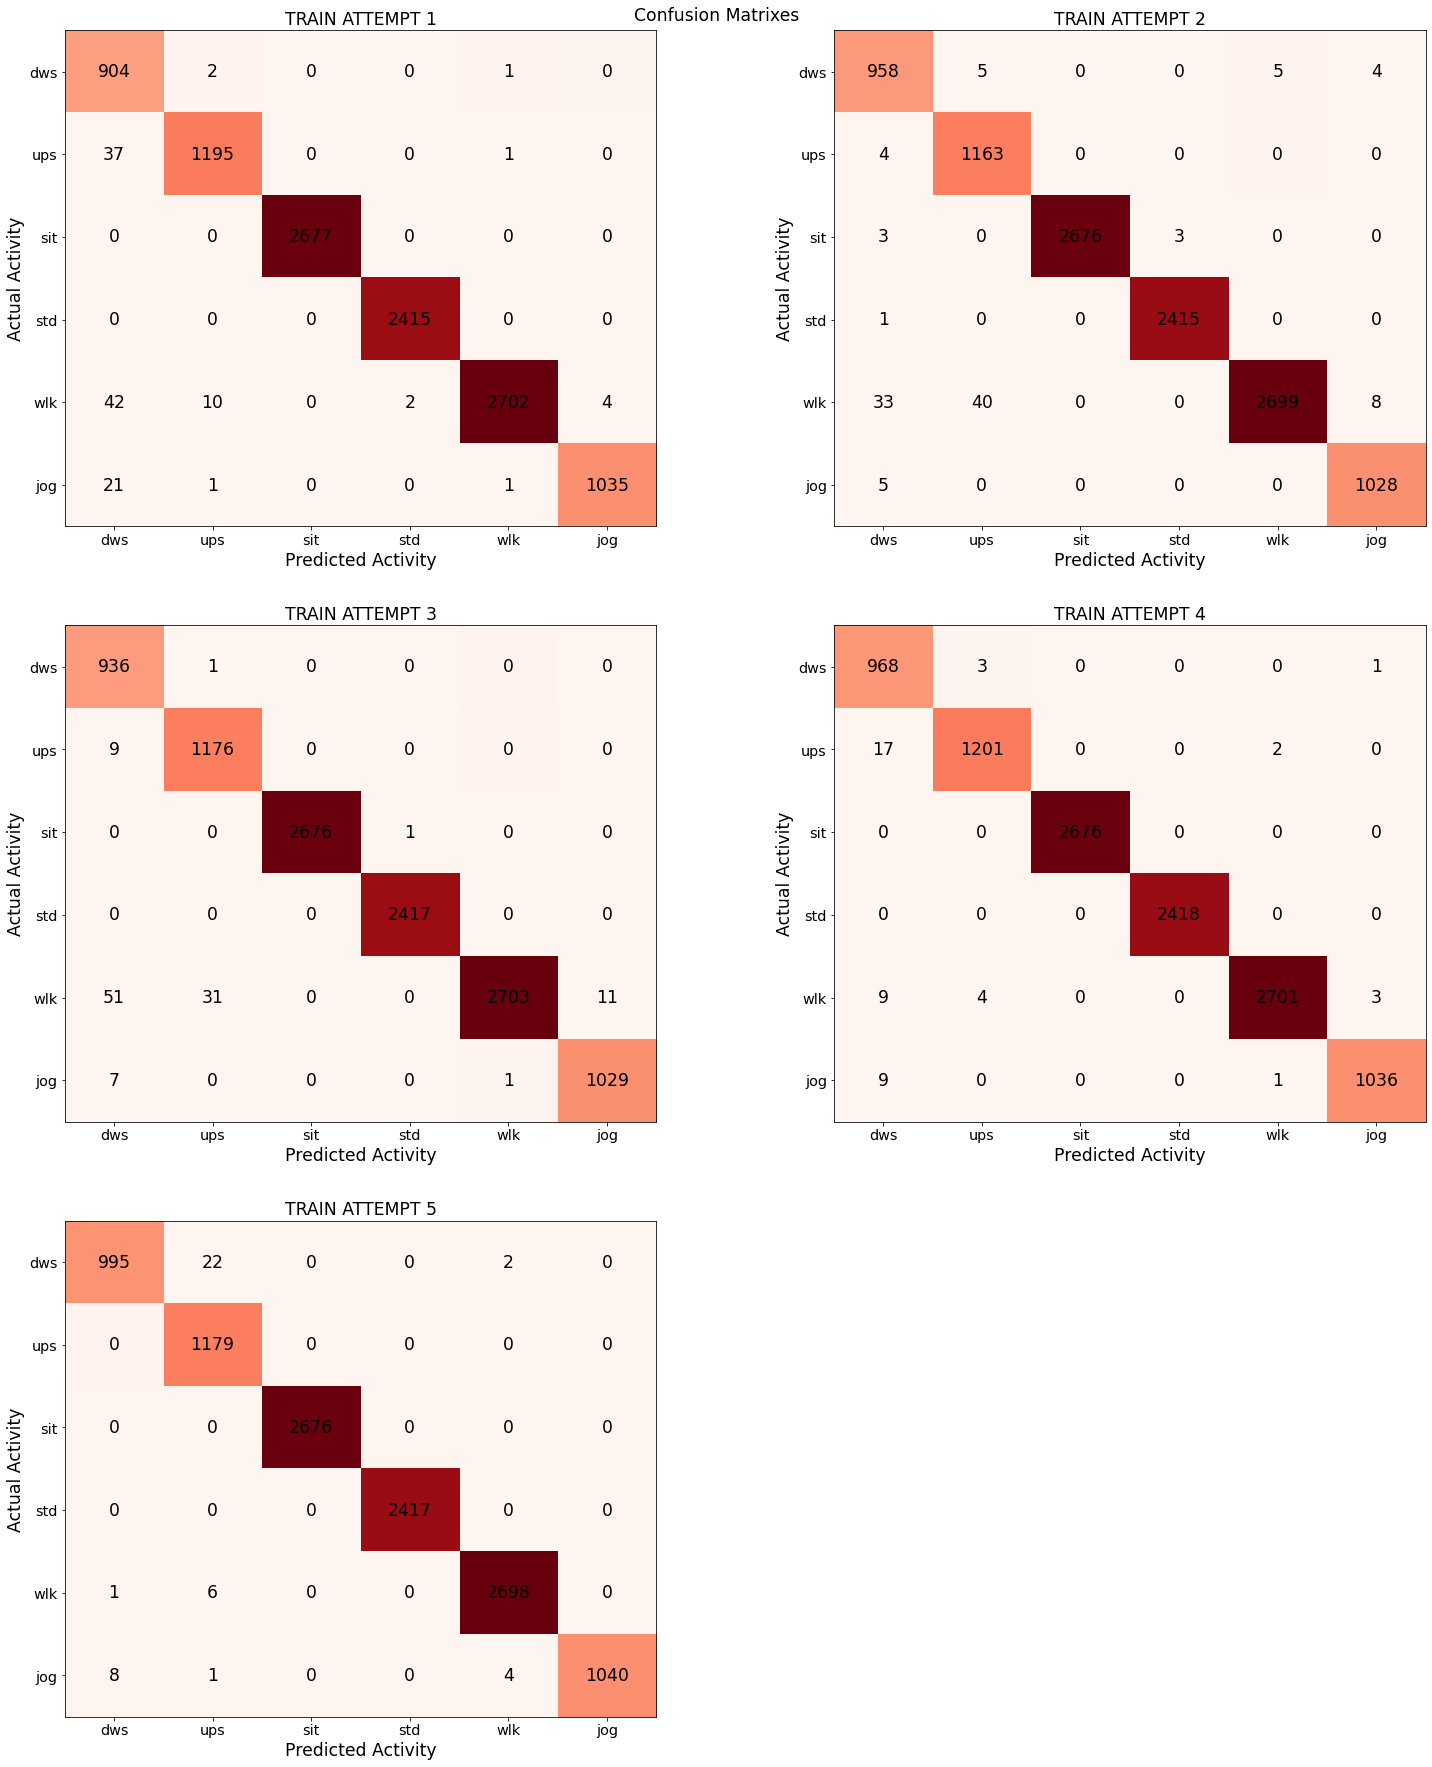

In [15]:
activities = ['dws', 'dws', 'ups', 'sit', 'std', 'wlk', 'jog']

fig = plt.figure(figsize = (20,25))
fig.suptitle("Confusion Matrixes", fontsize = "xx-large")

for index, m in enumerate(matrixes):
    sp = fig.add_subplot(3,2,index + 1)
    sp.imshow(m, cmap="Reds", aspect='auto')
    sp.set_title("TRAIN ATTEMPT " + str(index + 1), fontsize = "xx-large")

    for i in range(6):
        for j in range(6):
            sp.text(i, j, m[i, j], ha="center", va="center", color="black", fontsize = "xx-large")

    sp.set_xticklabels(activities, fontsize = "x-large")
    sp.set_yticklabels(activities, fontsize = "x-large")
    
    sp.set_ylabel("Actual Activity", fontsize = "xx-large")
    sp.set_xlabel("Predicted Activity", fontsize = "xx-large")

fig.tight_layout()
fig.subplots_adjust(wspace = 0.3, hspace = 0.2)
plt.show()